In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from networkx.algorithms import community, bipartite

### Load Data

In [2]:
df = pd.read_csv("all_coins_data.csv")
df.time = pd.to_datetime(df.time)
nodes = list(set(df.coin))#Get unique list of coins
stablecoins = ["USDT","DAI","USDC","BUSD", "TUSD"]
volatile_coins = ["BNB", "ADA","DOT", "ETH", "BTC", "FTT", "ALGO","ATOM","BCH", "BSV",
                 "CRO", "CTC", "DASH", "ETC", "EOS", "HEDG", "HEX", "HT","LEO", "LINK", "LTC","MIOTA",
                  "MKR","NEO","OKB","OMG", "ONT","SNX","THETA","TRX","UMA","VET", "WBTC", 'XEM', 'XLM',
                   'XMR', 'XRP', 'XTZ', 'YFI', 'ZEC']
df["stablecoin"] = [1 if c in stablecoins else 0 for c in df["coin"]]
df.to_csv("df_app_data.csv", sep=";", index = False)

#### Return Analysis

In [3]:
df[["time", "close", "coin"]].pivot(index = "time",columns="coin", values = "close").head()

coin,ADA,ALGO,ATOM,BCH,BNB,BSV,BTC,BUSD,CRO,CTC,...,USDT,VET,WBTC,XEM,XLM,XMR,XRP,XTZ,YFI,ZEC
time,,,,,,,,,,,,,,,,,,,,,
2020-08-22,0.1253,0.5648,6.423,286.66,22.22,196.53,11670.42,1.0000,0.1700,0.01249,...,1.000,0.0182,11950.51,0.08146,0.10220,94.59,0.2862,3.579,14062.86,76.86
2020-08-23,0.1215,0.6141,8.532,284.62,21.85,194.11,11651.52,1.0000,0.1718,0.01247,...,1.000,0.0178,11535.00,0.09548,0.10290,91.29,0.2849,3.517,12513.73,84.40
2020-08-24,0.1237,0.6302,8.204,290.89,22.61,203.97,11756.40,1.0000,0.1760,0.01258,...,1.000,0.0182,11638.84,0.09190,0.10300,93.73,0.2887,3.680,14472.13,80.29
2020-08-25,0.1126,0.5621,8.389,275.90,21.41,191.83,11330.56,1.0010,0.1698,0.01212,...,1.001,0.0169,11183.26,0.09386,0.09734,88.59,0.2767,3.437,13517.36,73.06
2020-08-26,0.1144,0.5502,7.715,274.86,22.22,190.92,11466.89,0.9999,0.1711,0.01227,...,1.000,0.0172,11696.23,0.09749,0.09804,88.99,0.2765,3.370,15686.71,74.98


In [4]:
df_return_wide = df[["time", "close", "coin"]].pivot(index = "time",columns="coin", values = "close").pct_change()
df_return_wide.head()

coin,ADA,ALGO,ATOM,BCH,BNB,BSV,BTC,BUSD,CRO,CTC,...,USDT,VET,WBTC,XEM,XLM,XMR,XRP,XTZ,YFI,ZEC
time,,,,,,,,,,,,,,,,,,,,,
2020-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-23,-0.030327,0.087288,0.328351,-0.007116,-0.016652,-0.012314,-0.001619,0.000000,0.010588,-0.001601,...,0.000000,-0.021978,-0.034769,0.172109,0.006849,-0.034887,-0.004542,-0.017323,-0.110158,0.098100
2020-08-24,0.018107,0.026217,-0.038444,0.022029,0.034783,0.050796,0.009001,0.000000,0.024447,0.008821,...,0.000000,0.022472,0.009002,-0.037495,0.000972,0.026728,0.013338,0.046346,0.156500,-0.048697
2020-08-25,-0.089733,-0.108061,0.022550,-0.051532,-0.053074,-0.059519,-0.036222,0.001000,-0.035227,-0.036566,...,0.001000,-0.071429,-0.039143,0.021328,-0.054951,-0.054838,-0.041566,-0.066033,-0.065973,-0.090049
2020-08-26,0.015986,-0.021171,-0.080343,-0.003769,0.037833,-0.004744,0.012032,-0.001099,0.007656,0.012376,...,-0.000999,0.017751,0.045869,0.038675,0.007191,0.004515,-0.000723,-0.019494,0.160486,0.026280


In [5]:
df["stablecoin"] = [1 if c in stablecoins else 0 for c in df["coin"]]
df_long = pd.melt(df, id_vars=["coin","time", "stablecoin"], value_vars=["high","low","open","volumefrom","volumeto","close","daily_return_pct","intraday_return","daily_log_return"], ignore_index=False).set_index("time")
df_long.head()

,coin,stablecoin,variable,value
time,,,,
2020-08-22,ADA,0,high,0.1262
2020-08-23,ADA,0,high,0.1259
2020-08-24,ADA,0,high,0.1270
2020-08-25,ADA,0,high,0.1238
2020-08-26,ADA,0,high,0.1183


### Correlation Matrix

In [6]:
def corr_matrix_plot(df, metric):
    long_corr= df[df["variable"]==metric].pivot(columns = "coin", values = "value").corr()
    np.fill_diagonal(long_corr.values, 0)
    sns.clustermap(long_corr, figsize=(15, 15),cmap="Blues")
    return plt

<module 'matplotlib.pyplot' from '/home/fede/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

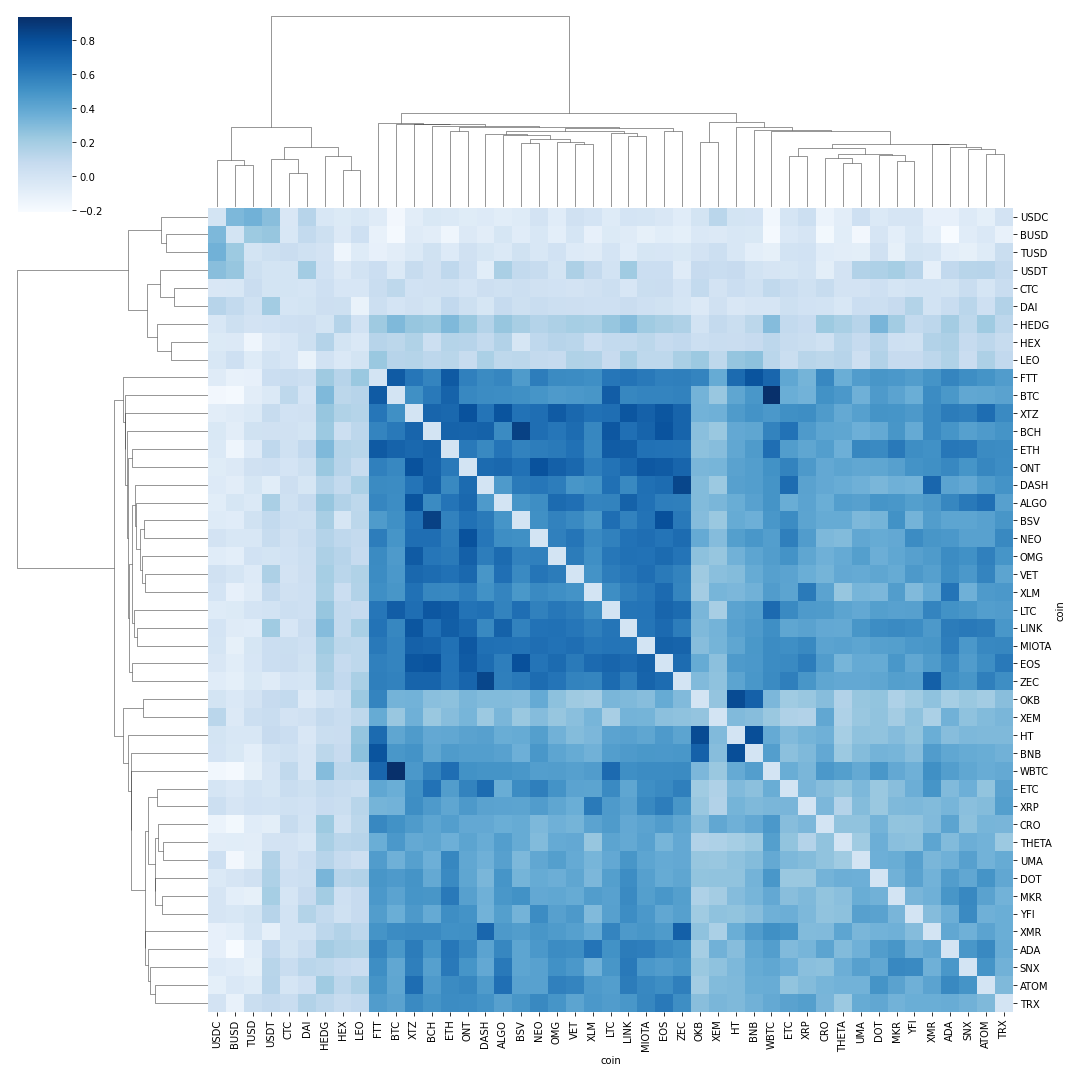

In [7]:
corr_matrix_plot(df_long, "daily_log_return")

In [8]:
# Correlation matrix for all periods
def corr_long_matrix(df, metric):
    long_corr= df[df["variable"]==metric].pivot(columns = ["coin"], values = "value").corr().stack().to_frame()
    long_corr.index.set_names(["coin","coin2"], inplace=True)
    long_corr.reset_index(inplace=True)
    long_corr.rename(columns={0:"corr"}, inplace = True)
    long_corr = long_corr[long_corr["coin"]!=long_corr["coin2"]]
    long_corr["stablecoin"] = [1 if c in stablecoins else 0 for c in long_corr["coin"]]
    return long_corr

corr_df = corr_long_matrix(df_long, "daily_log_return")

count    1980.000000
mean        0.309292
std         0.240525
min        -0.207258
25%         0.081984
50%         0.344697
75%         0.490242
max         0.932428
Name: corr, dtype: float64

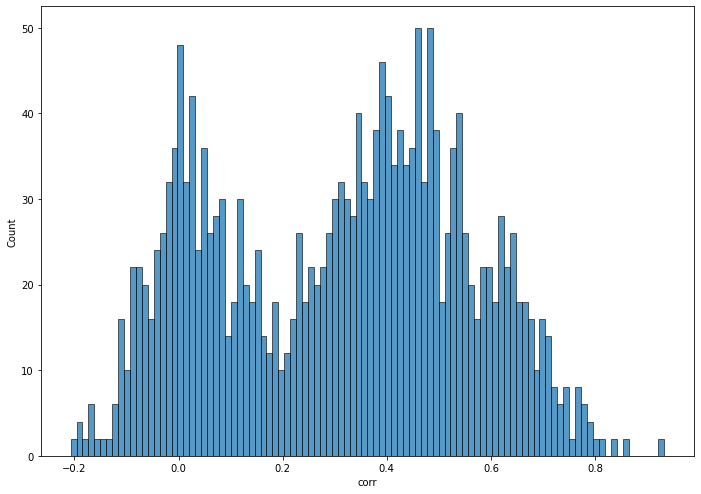

In [9]:
from matplotlib import pyplot
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=(a4_dims))
sns.histplot(corr_df, x = "corr", bins = 100)
corr_df["corr"].describe()

In [10]:
# Create a range for all correlations
corr_range = []
corr_range.append(corr_df["corr"].min())
while corr_range[-1]<corr_df["corr"].max():
    corr_range.append(corr_range[-1]+0.01)
corr_range.append(corr_df["corr"].max())

### Create Graph

In [11]:
def create_graph(corrdf, stablecoins, volatile_coins):
    G = nx.Graph()
    G.add_nodes_from(stablecoins, stablecoin = 1)
    G.add_nodes_from(volatile_coins, stablecoin = 0)
    for index, row in corrdf.iterrows(): 
        G.add_edge(row["coin"], row["coin2"], weight = row["corr"])
    return G

#### Graph charts

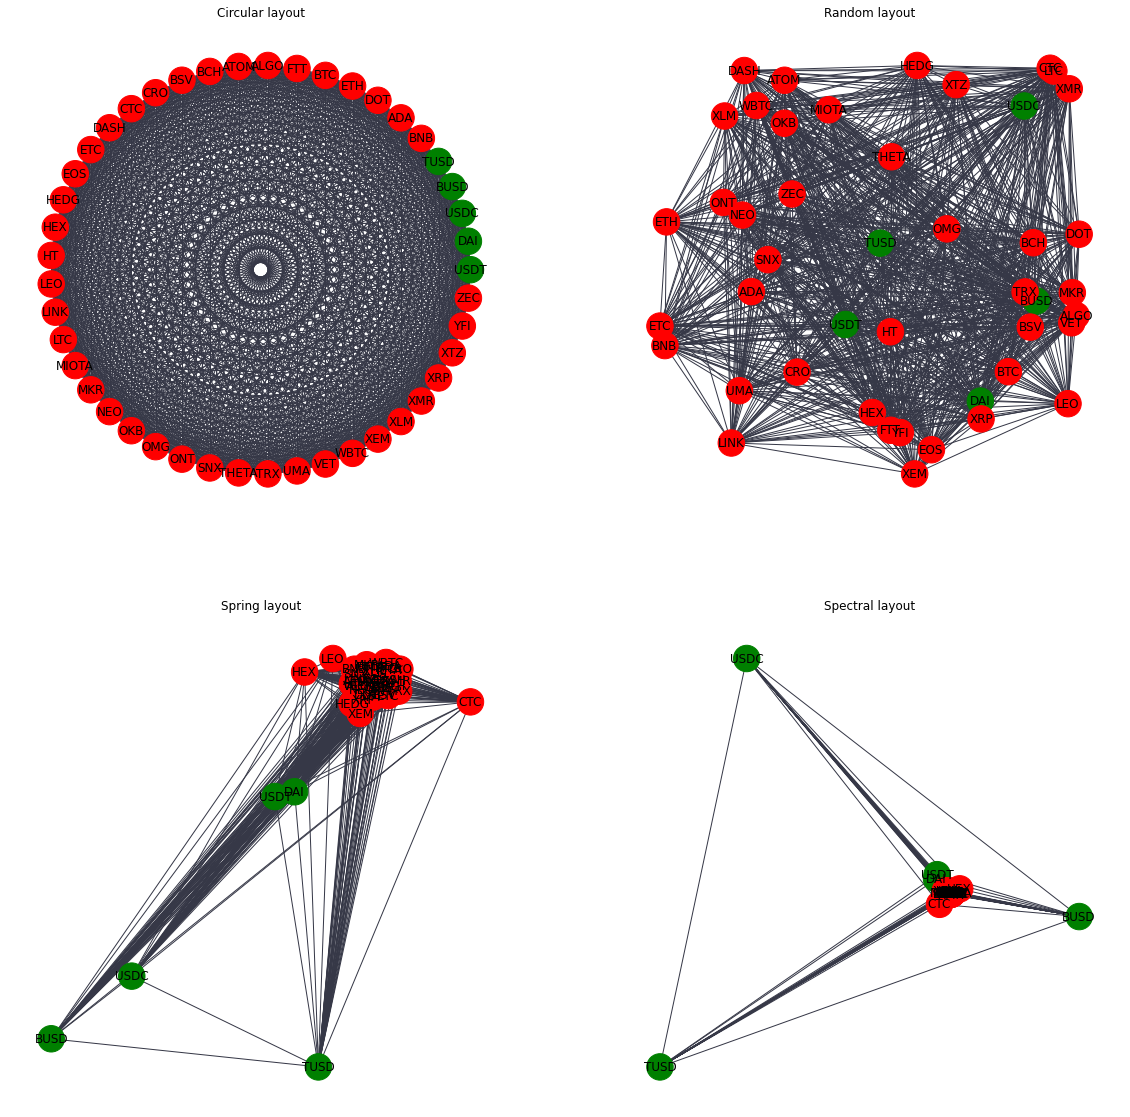

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
G = create_graph(corr_df, stablecoins, volatile_coins)
color_map = []

for node in G:
        if node in stablecoins: 
                color_map.append("green")
        else:
                color_map.append("red")

nx.draw(G, with_labels=True, node_size=700, node_color=color_map,
        edge_color='#363847',  pos=nx.circular_layout(G),ax=ax[0,0])
ax[0,0].set_title("Circular layout")

nx.draw(G, with_labels=True, node_size=700, node_color=color_map,
        edge_color='#363847',  pos=nx.random_layout(G),ax=ax[0,1])
ax[0,1].set_title("Random layout")

nx.draw(G, with_labels=True, node_size=700, node_color=color_map,
        edge_color='#363847',  pos=nx.spring_layout(G),ax=ax[1,0])
ax[1,0].set_title("Spring layout")

nx.draw(G, with_labels=True, node_size=700, node_color=color_map,
        edge_color='#363847',  pos=nx.spectral_layout(G),ax=ax[1,1])
ax[1,1].set_title("Spectral layout")

plt.show()

<module 'matplotlib.pyplot' from '/home/fede/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

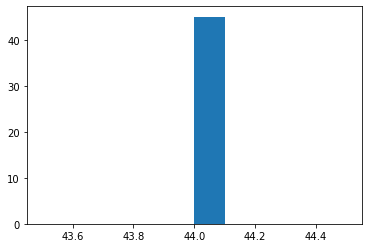

In [13]:
def plot_degree_distribution(G):
    degree = [G.degree(n) for n in G.nodes()]
    plt.hist(degree)
    return plt

plot_degree_distribution(G)

#### MST

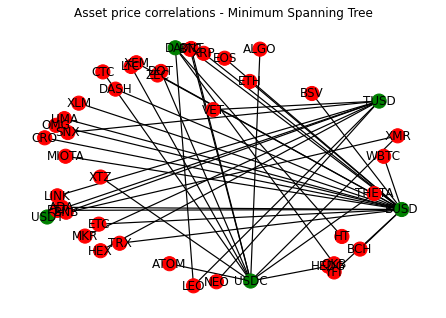

In [14]:
mst = nx.minimum_spanning_tree(G)
color_map = []

for node in mst:
    if node in stablecoins:
        color_map.append('green')
    else: 
        color_map.append('red')      
nx.draw(mst, with_labels=True, pos=nx.fruchterman_reingold_layout(mst),
        node_size=200, node_color=color_map, width = 1.2)

plt.title("Asset price correlations - Minimum Spanning Tree")
plt.show()

#### Community detection

In [15]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

def girvan_newman(graph):
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [16]:
c = girvan_newman(G.copy())
# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

node_groups

[['USDT'],
 ['BUSD',
  'EOS',
  'DAI',
  'ETC',
  'VET',
  'ALGO',
  'OKB',
  'HEX',
  'THETA',
  'XEM',
  'XTZ',
  'BSV',
  'BCH',
  'TRX',
  'WBTC',
  'TUSD',
  'XMR',
  'OMG',
  'ATOM',
  'XRP',
  'CTC',
  'ZEC',
  'CRO',
  'LEO',
  'ADA',
  'FTT',
  'ONT',
  'DASH',
  'HEDG',
  'YFI',
  'HT',
  'LINK',
  'BTC',
  'DOT',
  'ETH',
  'MKR',
  'XLM',
  'NEO',
  'LTC',
  'UMA',
  'USDC',
  'BNB',
  'MIOTA',
  'SNX']]

### Find correlation treshold

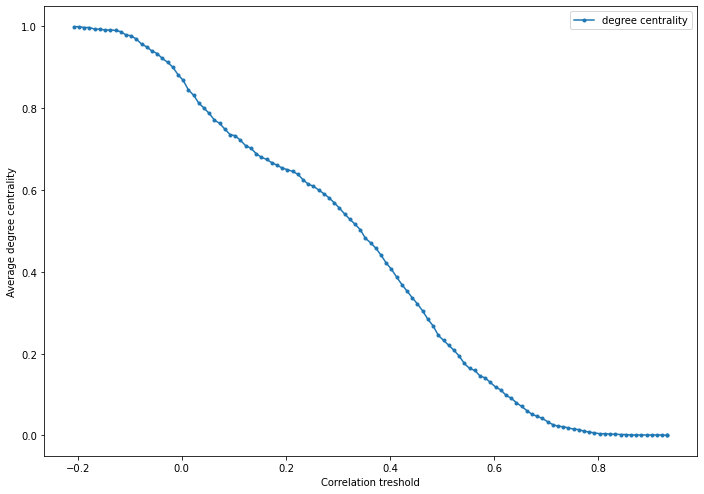

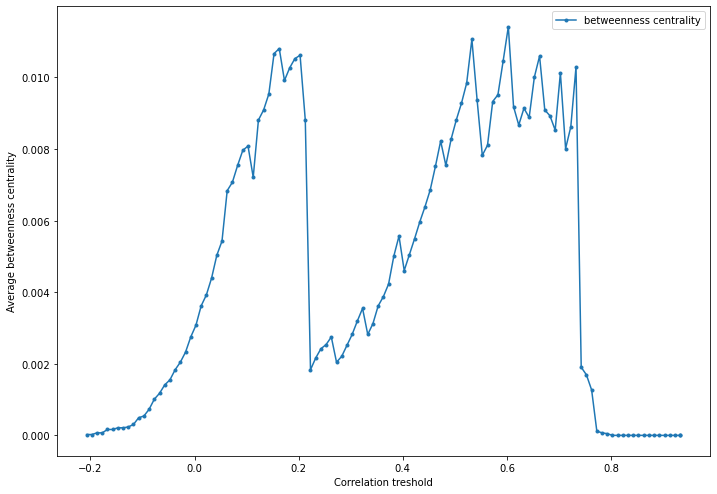

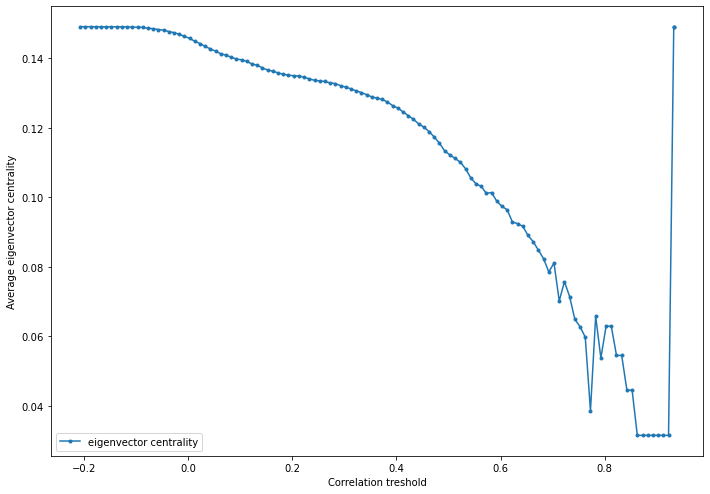

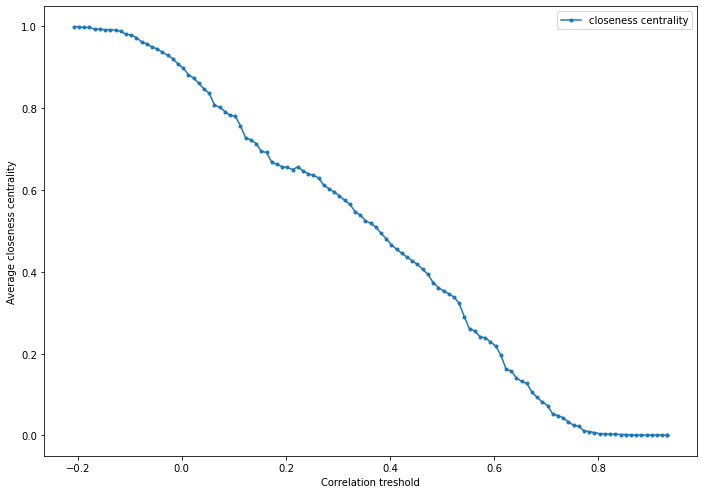

In [17]:
centrality_functions = {
    'degree centrality': nx.degree_centrality,
    'betweenness centrality': nx.betweenness_centrality,
    'eigenvector centrality': nx.eigenvector_centrality,
    'closeness centrality': nx.closeness_centrality
    }

for f_name, f in centrality_functions.items():
    mean_values = []
    for c in corr_range:
        G = create_graph(corr_df[corr_df["corr"] > c], stablecoins, volatile_coins)
        mean_values.append(np.mean(list(f(G).values())))
    pyplot.figure(figsize=a4_dims)
    plt.plot(corr_range, mean_values, '.-', label = f_name)
    plt.xlabel('Correlation treshold')
    plt.ylabel('Average %s' % f_name)
    plt.legend()
    plt.show()

#### Treshold is at .2

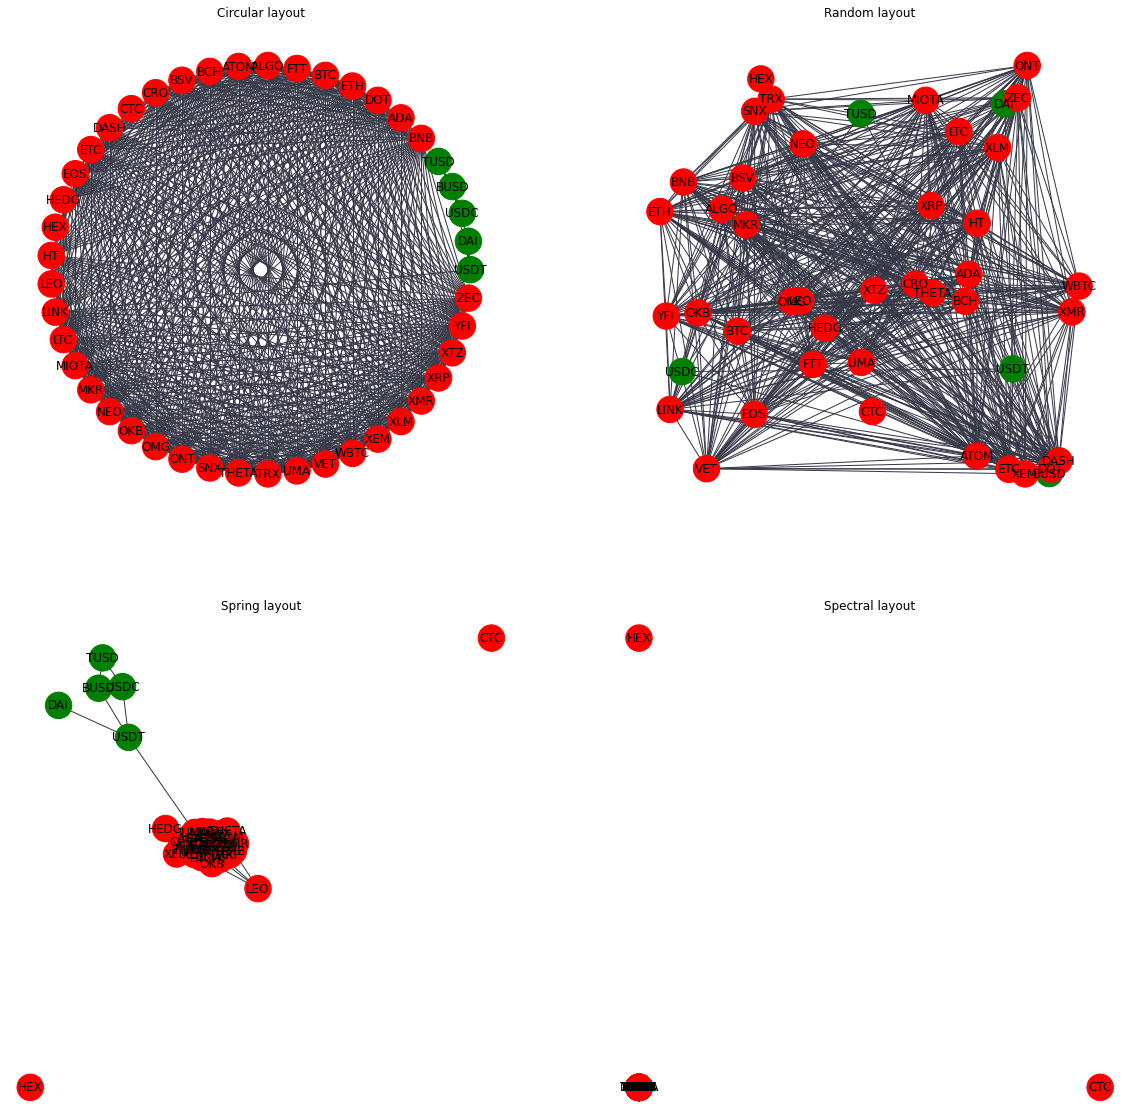

In [18]:
G = create_graph(corr_df[corr_df["corr"] >= .2], stablecoins, volatile_coins)
color_map = []
for node in G:
    if node in stablecoins:
        color_map.append('green')
    else: 
        color_map.append('red')

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,20))

nx.draw(G, with_labels=True, node_size=700, node_color=color_map,
        edge_color='#363847',  pos=nx.circular_layout(G),ax=ax[0,0])
ax[0,0].set_title("Circular layout")

nx.draw(G, with_labels=True, node_size=700, node_color=color_map,
        edge_color='#363847',  pos=nx.random_layout(G),ax=ax[0,1])
ax[0,1].set_title("Random layout")

nx.draw(G, with_labels=True, node_size=700, node_color=color_map,
        edge_color='#363847',  pos=nx.spring_layout(G),ax=ax[1,0])
ax[1,0].set_title("Spring layout")

nx.draw(G, with_labels=True, node_size=700, node_color=color_map,
        edge_color='#363847',  pos=nx.spectral_layout(G),ax=ax[1,1])
ax[1,1].set_title("Spectral layout")

plt.show()

#### MST with treshold

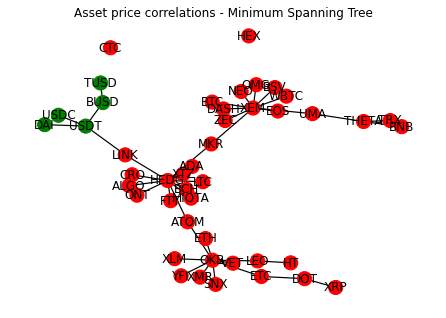

In [19]:
mst = nx.minimum_spanning_tree(G)

color_map = []
for node in mst:
    if node in stablecoins:
        color_map.append('green')
    else: 
        color_map.append('red')
nx.draw(mst, with_labels=True, pos=nx.fruchterman_reingold_layout(mst),
        node_size=200, node_color=color_map, width = 1.2)

plt.title("Asset price correlations - Minimum Spanning Tree")
plt.show()

In [20]:
c = girvan_newman(G.copy())
# find the nodes forming the communities
node_groups = []
tuple(sorted(c) for com in next(c))


([{'CTC'}, {'HEX'}],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [])

In [22]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()


KeyError: 'pos'

In [28]:
for edge in G.edges():
    print(G.nodes[edge[0]])

{'stablecoin': 1}
{'stablecoin': 1}
{'stablecoin': 1}
{'stablecoin': 1}
{'stablecoin': 1}
{'stablecoin': 1}
{'stablecoin': 1}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stablecoin': 0}
{'stableco